In [2]:
import numpy as np
import scipy.spatial as spatial
import scipy.cluster as clstr
from time import time
from collections import defaultdict
from functools import partial
from sklearn.utils import shuffle
import cv2 as cv
import math
from matplotlib import pyplot as plt
import numpy as np
import datetime
from scipy.spatial.distance import pdist, squareform

MAX_WIDTH = 1000
DESIRED_WIDTH = 2000

def resize_image(img):
    """
    Resizes the image to a maximum width of 1440px
    """
    width = img.shape[1]
    if width > MAX_WIDTH:
        scale = MAX_WIDTH / width
        return cv.resize(img, None, fx=scale, fy=scale)
    else:
        return img
        
def binarize_image(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    gaussian_blur = cv.GaussianBlur(gray,(5,5),0)
    ret,otsu_binary = cv.threshold(gaussian_blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return otsu_binary
    
def auto_canny(img, sigma=0.3):
    v = np.median(img)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edges = cv.Canny(img, lower, upper)
    return edges
     
def hough_line(edge):
    lines = cv.HoughLines(edge, 1, np.pi/180, threshold=130)
    lines = np.reshape(lines, (-1, 2))
    return lines

def draw_lines(lines,img):
    img_copy = img.copy()
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 4000*(-b))
        y1 = int(y0 + 4000*(a))
        x2 = int(x0 - 4000*(-b))
        y2 = int(y0 - 4000*(a))
        cv.line(img_copy,(x1,y1),(x2,y2),(0,0,255),2)
    return img_copy
    
def hor_vert_lines(lines):
    # A line is given by rho and theta. Given a list of lines, returns a list of
    # horizontal lines (theta=90 deg) and a list of vertical lines (theta=0 deg).
    h = []
    v = []
    for i in range(0, len(lines)):
        rho = lines[i,0]
        theta = lines[i,1]
        if theta < np.pi / 4 or theta > np.pi - np.pi / 4:
            v.append([rho, theta])
        else:
            h.append([rho, theta])
    return h, v

def intersections(h, v):
    # Given lists of horizontal and vertical lines in (rho, theta) form, returns list
    # of (x, y) intersection points.
    points = []
    for d1, a1 in h:
        for d2, a2 in v:
            A = np.array([[np.cos(a1), np.sin(a1)], [np.cos(a2), np.sin(a2)]])
            b = np.array([d1, d2])
            point = np.linalg.solve(A, b)
            points.append(point)
    return np.array(points)

def cluster(points, max_dist=10):
    # Given a list of points, returns a list of cluster centers.
    Y = spatial.distance.pdist(points)
    Z = clstr.hierarchy.single(Y)
    T = clstr.hierarchy.fcluster(Z, max_dist, 'distance')
    clusters = defaultdict(list)
    for i in range(len(T)):
        clusters[T[i]].append(points[i])
    clusters = clusters.values()
    clusters = map(lambda arr: (np.mean(np.array(arr)[:,0]), np.mean(np.array(arr)[:,1])), clusters)
    result = []
    for point in clusters:
        result.append([point[0], point[1]])
    return result

def draw_points(points,img):
    # Draw points on image
    img_copy = img.copy()
    points = np.array(points, dtype = 'int32')
    for point in points:
        cv.circle(img_copy, point, 10, (255, 0, 0) , -1)
    return img_copy
        
def euclidean_distance(points, loc):
    dis_array = []
    for point in points:
        dis_array.append(np.linalg.norm(point - loc,ord = 2))
    #print(dis_array)
    return np.array(dis_array, dtype = 'f')

def find_corners(points, H,W):
    scale = MAX_WIDTH / W
    print(scale)
    # Given a list of points, returns a list containing the four corner points.
    top_left = np.argmin(euclidean_distance(points, np.array([0 , 0])))
    top_right = np.argmin(euclidean_distance(points, np.array([0 , H])))
    bottom_left = np.argmin(euclidean_distance(points, np.array([W, 0])))
    bottom_right = np.argmin(euclidean_distance(points, np.array([W, H])))
    
    corners = [points[top_left], points[top_right], points[bottom_left], points[bottom_right]] 
    
    # Scale corner points back to original size
    true_corners = [[x[0] / scale, x[1] / scale] for x in corners]
    return true_corners
    
def get_image_from_four_points(image, pts):
    # Define the desired output dimensions
    width = DESIRED_WIDTH
    height = DESIRED_WIDTH
    pts = np.array(pts, dtype =np.float32)
    # Define the destination points for the perspective transformation
    dst_pts = np.array([[0, 0], [0, height -1], [width - 1, 0], [width - 1, height - 1]], dtype=np.float32)

    # Compute the perspective transformation matrix
    M = cv.getPerspectiveTransform(pts, dst_pts)

    # Apply the perspective transformation
    warped = cv.warpPerspective(image, M, (width, height))

    return warped

def split_board(img):
    """
    Given a board image, returns an array of 64 smaller images.
    """
    arr = []
    sq_len = img.shape[0] // 8
    for i in range(8):
        for j in range(8):
            arr.append(img[i * sq_len : (i + 1) * sq_len, j * sq_len : (j + 1) * sq_len])
    return arr

def remove_points_every_11(points):
    sorted_points = sorted(points, key=lambda p: (p[1], p[0]))
    result = []
    # Iterate over the list in chunks of 11
    for i in range(0, len(sorted_points), 11):
        chunk = sorted_points[i:i + 11]
        # Remove the 0th point and 10th point (if they exist)
        filtered_chunk = [pt for j, pt in enumerate(chunk) if j != 0 and j != 10]
        result.extend(filtered_chunk)
    return result


In [71]:
import cv2 as cv

for i in range(5):
    cam = cv.VideoCapture(i, cv.CAP_DSHOW)
    if cam.isOpened():
        print(f"Camera found at port {i}")
        cam.release()
    else:
        print(f"No camera found at port {i}")

Camera found at port 0
Camera found at port 1
No camera found at port 2
No camera found at port 3
No camera found at port 4


In [72]:
cam = cv.VideoCapture(1, cv.CAP_DSHOW)
cam.set(cv.CAP_PROP_FRAME_WIDTH, 4000)
cam.set(cv.CAP_PROP_FRAME_HEIGHT, 2160)

True

Actual resolution set to: 3840x2160


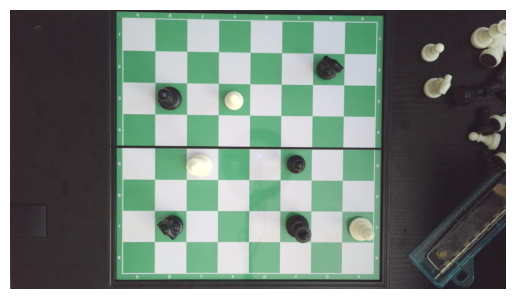

Captured image shape: (2160, 3840, 3)


In [73]:
# Check if the camera opened successfully
if not cam.isOpened():
    print("Failed to open camera")
else:
    # Set frame resolution (1440x2560) or your preferred resolution
    

    # Verify the actual resolution
    width = int(cam.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cam.get(cv.CAP_PROP_FRAME_HEIGHT))
    print(f"Actual resolution set to: {width}x{height}")
    
    # Capture a frame
    result, original = cam.read()

    if result:
        # Convert BGR to RGB for correct color display in Matplotlib
        original_rgb = cv.cvtColor(original, cv.COLOR_BGR2RGB)
        
        # Display the image
        plt.imshow(original_rgb)
        plt.axis('off')
        plt.show()
        
        # Save the image
        cv.imwrite("test1.jpeg", original)
        print(f"Captured image shape: {original.shape}")
    else:
        print("Failed to capture image")

In [74]:
cam.release()

In [4]:
today = datetime.date.today().strftime("%m%d")

if __name__ == "__main__":
    # Get image and display it
    # original = cv.imread('1.png')
    H,W,_ = original.shape
    img = resize_image(original)    
    plt.imshow(img)
    plt.figure()

    # Turn image into BW (black white image)
    BW = binarize_image(img)
    plt.imshow(BW,cmap = 'gray')
    plt.figure()
    
    # Use Canny technique to get the edges of image
    edge = auto_canny(BW)
    plt.imshow(edge,cmap = 'gray')
    plt.figure()
    
    # Use Houghline to detech lines and plot image
    lines = hough_line(edge)
    plt.imshow(draw_lines(lines, img))
    plt.figure()
    
    # Find the intersections of horizon and vertical lines, cluster them and display on the image:
    h,v = hor_vert_lines(lines)
    points = intersections(h,v)
    img_points = draw_points(points,img)
    plt.imshow(img_points)
    plt.figure()
    clustered_points = cluster(points, max_dist=20)
    img_intersection = draw_points(clustered_points,img)
    plt.imshow(img_intersection)
    plt.figure()


    # Find corners:
    corners = find_corners(clustered_points,H,W)
    img_corner = draw_points(corners,original)
    plt.imshow(img_corner)
    plt.figure()

    # Get the board
    warp = get_image_from_four_points(original, corners)
    plt.imshow(warp)
    path = f"board/{today}_6.jpg"
    cv.imwrite(path,warp)
 

NameError: name 'glob' is not defined

In [11]:
   # Split the image board:
from glob import glob
today = datetime.date.today().strftime("%m%d")
images = glob('C:/Users/tttha/Downloads/ChessPieces.v1i.yolov5pytorch/train/images/*')
for i in range(0,len(images)):
    original = cv.imread(images[i])  
    arr = split_board(original)
    for j in range(0,len(arr)):
        src = arr[j]
        for angle in range(0, 360, 90):  
            rotated_image = cv.rotate(src, cv.ROTATE_90_COUNTERCLOCKWISE)
            src = cv.resize(rotated_image,(224,224))
            path = f"data/{today}_{i}_{j}_{angle}.jpg"
            cv.imwrite(path,src)
    
print("Done")

Done


In [3]:
from glob import glob
today = datetime.date.today().strftime("%m%d")
images = glob('C:/Users/tttha/OneDrive/Pictures/Camera Roll 1/*')
for i in range(1,len(images)):
    original = cv.imread(images[i])
    H,W,_ = original.shape
    img = resize_image(original)    
        
        # Turn image into BW (black white image)
    BW = binarize_image(img)
        
        # Use Canny technique to get the edges of image
    edge = auto_canny(BW)
        
        # Use Houghline to detech lines and plot image
    lines = hough_line(edge)

        
        # Find the intersections of horizon and vertical lines, cluster them and display on the image:
    h,v = hor_vert_lines(lines)
    points = intersections(h,v)
  
    clustered_points = cluster(points, max_dist=20)
    

        # Find corners:
    corners = find_corners(clustered_points,H,W)
    
        # Get the board
    warp = get_image_from_four_points(original, corners)
    path = f"board/new_coming/{today}_{i}.jpg"
    cv.imwrite(path,warp)

0.2604166666666667
